In [1]:
%load_ext autoreload
%autoreload 2

In [16]:
from src.utils import Loader
from src.execution import Tester

problemId = 3
dataset_path = f'data/problemID_{problemId}/dataset.json'
loader = Loader()
problemId, description, buggys, references, testcases = loader.run(dataset_path)
prompts = f"""{description}

[reference code]
{references[0].code}
[buggy code]
{buggys[0].code}

please fix the buggy code and return the correct code.
"""

# print(prompts)
# print(testcases)
Tester.init_globals(testcases)

In [ ]:
from src.execution import Program
from src.utils import DIST, ETC

p_id = 20144
buggy = buggys.get_prog_by_id(str(p_id))
refer = references.get_prog_by_id(str(p_id))
code = """int main()
{
	int num1, num2, n = 0, i = 0;
	char p1 = '+', p2, p3;
	while (p1 == '*' || p1 == '/' || p1 == '+' || p1 == '-')
	{
		scanf("%d %c", &num1, &p2);
		while (p2 == '*' || p2 == '/')
		{
			scanf("%d %c", &num2, &p3);
			if (p2 == '*')
			{
				num1 *= num2;
				p2 = p3;
			}
			else if (p2 == '/')
			{
				num1 /= num2;
				p2 = p3;
			}
		}
		if (p1 == '+')
		{
			n += num1;
			p1 = p2;
		}
		else if (p1 == '-')
		{
			n -= num1;
			p1 = p2;
		}
	}
	printf("%d", n);
	return 0;
}
"""
patch = Program(id="patch", code=code, ext=buggy.ext)

## similarity
DIST.set_language(buggy.ext)
refer_dist = DIST.compute_levenshtein_ted(buggy.code, refer.code)
patch_dist = DIST.compute_levenshtein_ted(buggy.code, patch.code)
sim = ETC.divide((refer_dist - patch_dist), (refer_dist + patch_dist))
diff = DIST.compute_levenshtein_ted(refer.code, patch.code)

r_results = Tester.run(refer)
refer_time = r_results.exec_time()
refer_mem = r_results.mem_usage()

p_results = Tester.run(patch)
patch_time = p_results.exec_time()
patch_mem = p_results.mem_usage()

## execution time
exec_time = ETC.divide(
    (refer_time - patch_time), (refer_time + patch_time))
## memory usage
mem_usage = ETC.divide(
    (refer_mem - patch_mem), (refer_mem + patch_mem))

print(refer == patch, diff)
# print(f"Refer dist: {refer_dist}, Patch dist: {patch_dist}")
print(f"%Similarity: {sim}")
# print(f"Refer Time: {refer_time}, Patch Time: {patch_time}")
print(f"%Execution Time: {exec_time}")
# print(f"Refer Memory: {refer_mem}, Patch Memory: {patch_mem}")
print(f"%Memory Usage: {mem_usage}")
# print(buggy.code)
# print(refer.code)
# print(patch.code)
# print(refer.code == patch.code or diff == 0)

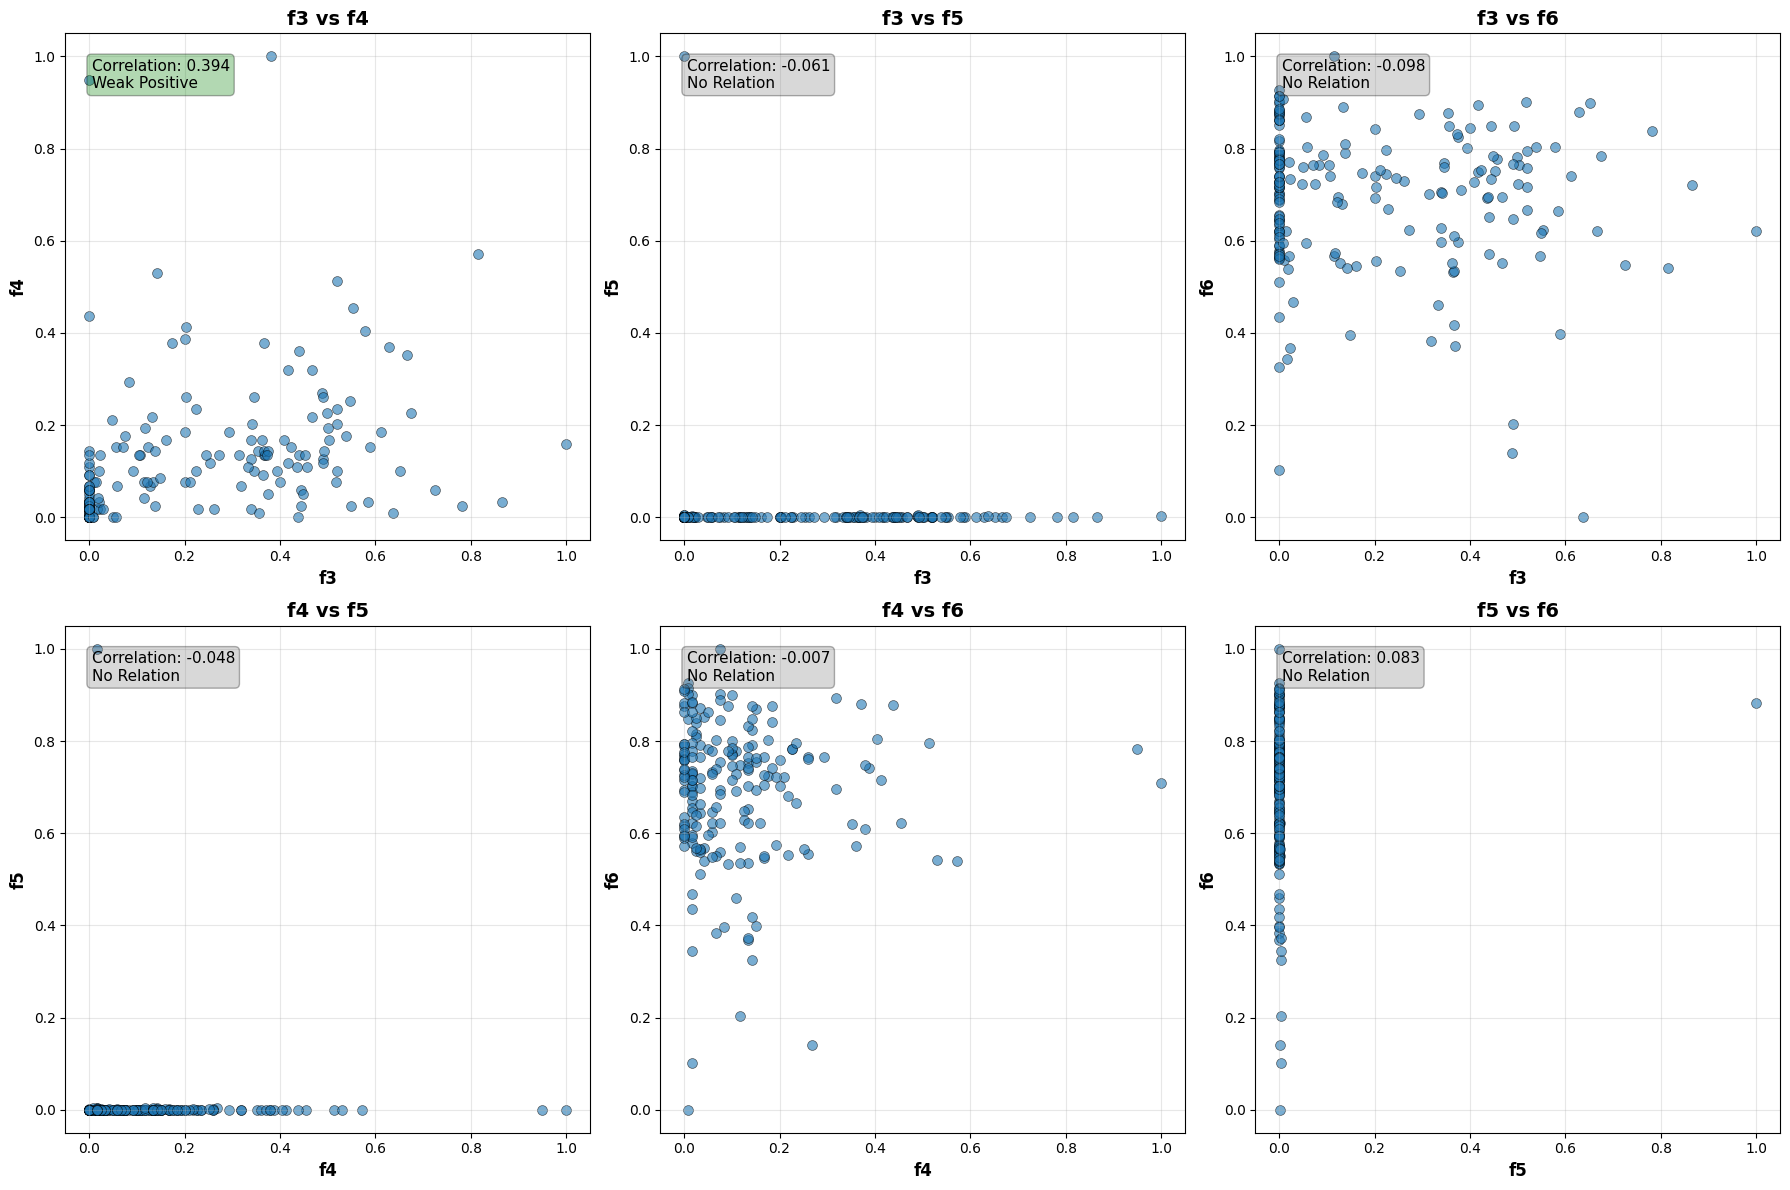


Correlation Matrix
              f3        f4        f5        f6
--------------------------------------------------
f3         1.000     0.394    -0.061    -0.098
f4         0.394     1.000    -0.048    -0.007
f5        -0.061    -0.048     1.000     0.083
f6        -0.098    -0.007     0.083     1.000

Interpretation Guide
Correlation > 0.7  : Strong Positive
0.3 < Correlation ≤ 0.7 : Weak Positive
-0.3 ≤ Correlation ≤ 0.3 : No Relation
-0.7 ≤ Correlation < -0.3 : Weak Negative
Correlation < -0.7 : Strong Negative


In [17]:
import matplotlib.pyplot as plt
import numpy as np
from itertools import combinations
from sklearn.preprocessing import MinMaxScaler

# 데이터 수집
from src.utils import DIST
DIST.set_language('c')

data = {'f3':[], 'f4':[], 'f5':[],'f6':[]}

for buggy in buggys:
    b_res = Tester.run(buggy)
    refer = references.get_prog_by_id(buggy.id)
    r_res = Tester.run(refer)
    
    b_cover = b_res.get_coverage_line()
    r_cover = r_res.get_coverage_line()
    
    b_passed, _ = Tester.tests_split(b_res)
    tc_scope_ids = {tc.id for tc in (b_passed if b_passed else set(Tester.testcases))}
    b_cover = {tc_id: b_cover[tc_id] for tc_id in tc_scope_ids}
    r_cover = {tc_id: r_cover[tc_id] for tc_id in tc_scope_ids}
    
    f3 = DIST.compute_ccd(
        b_cover, 
        r_cover)
    f4 = DIST.compute_levenshtein_ted(buggy.code, refer.code)
    f5 = r_res.exec_time()
    f6 = r_res.mem_usage()
    
    data['f3'].append(f3)
    data['f4'].append(f4)
    data['f5'].append(f5)
    data['f6'].append(f6)

# 목적함수 값 정규화
scaler = MinMaxScaler(feature_range=(0.0, 1.0))
for key in data:
    values = np.array(data[key]).reshape(-1, 1)
    scaled_values = scaler.fit_transform(values).flatten()
    data[key] = scaled_values.tolist()

# 목적함수 조합들
objectives = ['f3', 'f4', 'f5', 'f6']
obj_pairs = list(combinations(objectives, 2))

# 서브플롯 생성 (2x3 레이아웃)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# 각 쌍에 대해 산점도 그리기
for idx, (obj1, obj2) in enumerate(obj_pairs):
    ax = axes[idx]
    
    x = data[obj1]
    y = data[obj2]
    
    # 산점도
    ax.scatter(x, y, alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
    
    # 상관계수 계산
    corr = np.corrcoef(x, y)[0, 1]
    
    # 제목과 라벨
    ax.set_xlabel(obj1, fontsize=12, fontweight='bold')
    ax.set_ylabel(obj2, fontsize=12, fontweight='bold')
    ax.set_title(f'{obj1} vs {obj2}', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # 상관관계 판단 및 색상 설정
    if corr > 0.7:
        relation = "Strong Positive"
        color = 'darkgreen'
    elif corr > 0.3:
        relation = "Weak Positive"
        color = 'green'
    elif corr > -0.3:
        relation = "No Relation"
        color = 'gray'
    elif corr > -0.7:
        relation = "Weak Negative"
        color = 'orange'
    else:
        relation = "Strong Negative"
        color = 'darkred'
    
    # 상관계수와 관계 표시
    textstr = f'Correlation: {corr:.3f}\n{relation}'
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes,
            verticalalignment='top', fontsize=11,
            bbox=dict(boxstyle='round', facecolor=color, alpha=0.3))

plt.tight_layout()
plt.show()

# 상관계수 행렬 출력
print("\n" + "="*50)
print("Correlation Matrix")
print("="*50)
print(f"{'':6s}", end='')
for obj in objectives:
    print(f"{obj:>10s}", end='')
print()
print("-"*50)

for obj1 in objectives:
    print(f"{obj1:6s}", end='')
    for obj2 in objectives:
        if obj1 == obj2:
            corr = 1.0
        else:
            corr = np.corrcoef(data[obj1], data[obj2])[0, 1]
        print(f"{corr:10.3f}", end='')
    print()

print("\n" + "="*50)
print("Interpretation Guide")
print("="*50)
print("Correlation > 0.7  : Strong Positive")
print("0.3 < Correlation ≤ 0.7 : Weak Positive")
print("-0.3 ≤ Correlation ≤ 0.3 : No Relation")
print("-0.7 ≤ Correlation < -0.3 : Weak Negative")
print("Correlation < -0.7 : Strong Negative")
print("="*50)